In [1]:
from peak_warming_calculator import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rc('font', family='serif')

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from numpy import genfromtxt

In [3]:
import time

In [4]:
from varying_g_peak_warming_calculator import *

### MAC curve variables:
- P_50
- s
- P_100

### Economic variables:
- D0
- gamma
- alpha (discount factor)
- g (consumption growth rate)

## Varying MAC curve parameters

In [5]:
problem_3 = {
'num_vars': 2,
'names': ['P_50/P_100', 'P_100'],
'bounds': [[0.4, 0.8],
[100, 500]]
}
# Generate samples
param_values_2 = saltelli.sample(problem_3, 8)

In [6]:
P_100_list = []

for i in range(len(param_values_2)):
    P_100_list.append(param_values_2[i][1])

In [7]:
consumption_growth_array = np.linspace(0.01, 0.035, 6)

In [8]:
def vary_consumption_growth4(consumption_growth):
    Y = np.zeros([param_values_2.shape[0]])
    SCC_forecasted_0 = np.zeros([param_values_2.shape[0]])
    T_year_list = np.zeros([param_values_2.shape[0]])

#     consumption_growth = 0.020
    consumption_discount = consumption_growth + 0.015

    for i in range(len(param_values_2)):
        if i%8 == 0:
            print(i)
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            print(current_time)
        
        P_50 = param_values_2[i][0]*param_values_2[i][1]
        P_100 = param_values_2[i][1]
        r = consumption_discount
        constraint = 2.5  # param_values_2[i][1]
#         s = r * np.log(constraint)/np.log((P_100 - P0)/(P_50 - P0))
        s = r * np.log(constraint)/np.log((P_100)/(P_50))
        g_grad = 0.0001
#         if ((P_100 - P0) / (P_50 - P0)) ** (s / r) <= 2:
#             print("MAC curve condition not satisfied")

        Y[i], SCC_forecasted, forecasted_abatement, forecasted_emissions, T_complete = varying_g_peak_warming_calculator(P_50=P_50, s=s, P_100=P_100, g_2019=consumption_growth, consumption_discount=consumption_discount, r=r, return_all_output=True, g_grad=g_grad)
        SCC_forecasted_0[i] = SCC_forecasted[0]
        start_year = 1750
        peak_T = Y[i]
#         print(peak_T)
        T_year_list[i] = next(x[0] for x in enumerate(T_complete) if x[1] == peak_T) + start_year
        if Y[i] < 1.4:
            print(param_values_2[i][0])
            print(param_values_2[i][1])
            print(consumption_discount)
#             print(param_values_2[i][2])
    return Y, SCC_forecasted_0, T_year_list

In [9]:
Y_array = []
SCC_0_array = []
T_year_array = []

for i in range(1):  # len(consumption_growth_array)
    Y, SCC_0, T_year = vary_consumption_growth4(consumption_growth_array[i])
    Y_array.append(Y)
    SCC_0_array.append(SCC_0)
    T_year_array.append(T_year)

0
10:30:55


/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calculator/varying_g_peak_warming_calculator.py:270: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


8
10:32:35
16
10:37:43
24
10:39:51
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=80.78125
s=0.043068567996008916
r=0.025
P_100=137.5
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=101.40625
s=0.07523179472829122
r=0.025
P_100=137.5
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=101.40625
s=0.07523179472829122
r=0.025
P_100=137.5
32
10:45:37
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=77.34375
s=0.06113602554569291
r=0.025
P_100=112.5
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=77.34375
s=0.06113602554569291
r=0.025
P_100=112.5
40
10:49:45
convergence condition not achieved
consumption_discount=0.025
g_2019=0.01
P_50=71.71875000000001
s=0.050882313006092784
r=0.025
P_100=112.5


Text(0, 0.5, 'Peak Warming')

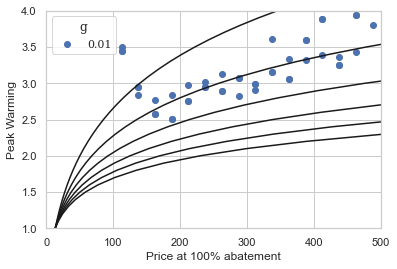

In [10]:
## plot output

for i in range(len(Y_array)):
    plt.scatter(P_100_list, Y_array[i], label=np.round(consumption_growth_array[i], 3))

# plt.legend()
plt.rc('font', family='serif')

## plot curves from Myles' paper

# W0 = 75*10**12  
W0 = 80*10**12  
D0 = 0.00267
T_TCRE = 0.00054  # degrees Celsius per GtCO2
# note: this corresponds to 0.002 degrees Celsius per GtC
r_minus_g = 0.015  # 1.5%
ks = 0.12  # per year

G = W0*D0*T_TCRE*(1/(r_minus_g)-1/(ks+r_minus_g))

gamma = 2
# E_0 = 39  # 2014 level of emissions
# percentage_of_emissions = 0.75  # set here the percentage of emisison
# E_bar = percentage_of_emissions*E_0
E_bar = 0.75*40.040508
# T_0 = 0.9  # 1.0136929156818866  # degrees Celsius
T_0 = 1.0136929156818866

T_m = np.arange(1, 5,0.1)
g_bar = consumption_growth_array  # np.arange(0.035, 0.04, 0.005)

for i in range(len(g_bar)):
    A_B = gamma*G*(T_m**(gamma-1))*np.exp((g_bar[i]/E_bar) * (T_m-T_0)/T_TCRE)
#     print(gamma, G, T_m)
#     print(np.exp((g_bar[i]/E_bar) * (T_m-T_0)/T_TCRE))
    plt.plot(A_B*10**(-9), T_m, color="k")  # convert cost into trillions of dollars # , label=g_bar[i]

plt.legend(title="g")
plt.xlim(0, 500)
plt.ylim(1, 4)
plt.xlabel("Price at 100% abatement")
plt.ylabel("Peak Warming")

In [11]:
# param_values_2

In [12]:
for i in range(len(param_values_2)):
    if param_values_2[i][1] == 112.5:
        print(param_values_2[i])
        print(Y_array[0][i])

[  0.6875 112.5   ]
3.443681185745996
[  0.6875 112.5   ]
3.443681185745996
[  0.6375 112.5   ]
3.5033068027224643


In [13]:
Y_array


[array([2.82516179, 3.07404897, 3.05702539, 3.05702539, 3.07404897,
        3.33354184, 3.80952601, 4.1278297 , 2.57796061, 2.57796061,
        4.1278297 , 2.7652582 , 2.84519011, 2.50789039, 3.94585979,
        3.94585979, 2.50789039, 3.42727728, 3.32090583, 3.60301837,
        2.89886194, 2.89886194, 3.60301837, 3.13481094, 2.83784456,
        2.95555508, 2.759934  , 2.759934  , 2.95555508, 2.97316853,
        3.60762937, 3.16157404, 3.88187992, 3.88187992, 3.16157404,
        3.39394756, 3.02049218, 2.94533795, 3.44368119, 3.44368119,
        2.94533795, 3.5033068 , 3.36232205, 3.25699827, 2.99423669,
        2.99423669, 3.25699827, 2.90627789])]